In [3]:
from ipynb.fs.full.Dataset_preparation import *
lupus_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 988 entries, 0 to 1201
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   treatment                      988 non-null    int64  
 1   outcome                        988 non-null    int64  
 2   diagnosis                      988 non-null    int64  
 3   symptome                       988 non-null    int64  
 4   etiology                       988 non-null    int64  
 5   epidemiologic                  988 non-null    int64  
 6   not_categorised                988 non-null    float64
 7   orginal_article                988 non-null    int64  
 8   metanalysis_systematic_review  988 non-null    int64  
 9   case_report                    988 non-null    int64  
 10  letter_short_common            988 non-null    int64  
 11  review                         988 non-null    int64  
 12  text                           988 non-null    ob

In [4]:
#Importing libraries to support glove file
from numpy import array
from numpy import asarray
from numpy import zeros
from matplotlib import pyplot

#importing pad_sequences for sequence from preprocessing class in keras library
from keras.preprocessing.sequence import pad_sequences
#Importing Tokenizer for text from preprocessing class in keras library   
from keras.preprocessing.text import Tokenizer

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, GlobalMaxPooling1D, LSTM, Conv1D, Conv2D,  Activation, Dropout, Input
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers.convolutional import MaxPooling1D

#Importing Adam from optimizers class in keras library
from keras.optimizers import Adam

#Importing ReduceLROnPlateau, EarlyStopping, ModelCheckpoint from callback function in keras library
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

#Importing tensorflow
import tensorflow as tf

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
nltk.download('wordnet')
from nltk.tokenize import word_tokenize

Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/enayat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/enayat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Pre processing

In [5]:
lst_stopwords = nltk.corpus.stopwords.words("english")
def preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and     characters and then strip)
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

lupus_dataset[['text']]=lupus_dataset[['text']].apply(lambda row: preprocess_text(row['text'],flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords),axis=1)
x=lupus_dataset['text']
lupus_dataset.head()


,treatment,outcome,diagnosis,symptome,etiology,epidemiologic,not_categorised,orginal_article,metanalysis_systematic_review,case_report,letter_short_common,review,text
0,0,0,0,0,1,0,0.0,0,1,0,0,0,association cd40 polymorphism systemic lupus e...
1,0,0,0,0,1,0,0.0,1,0,0,0,0,association paraoxonase 1and systemic lupus er...
2,0,1,0,1,0,0,0.0,1,0,0,0,0,difference clinical manifestation increased se...
3,0,0,1,0,0,0,0.0,1,0,0,0,0,clinical evaluation total high avidity anti ds...
4,0,0,0,1,0,0,0.0,1,0,0,0,0,clinical characteristic systemic lupus erythem...


 GloVe Embedding

In [9]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(lupus_dataset['text'])
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(lupus_dataset['text'])
# print(encoded_docs)
# pad documents to a max length of 200 words
max_length = 200
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
# print(padded_docs)
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt',encoding="utf8")
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()
# print('Loaded %s word vectors.' % len(embeddings_dictionary))
#Creating an object named as 'embedding_matrix' and assigning it matrix of zeros
embedding_matrix = zeros((vocab_size, 100))

#Creating For loop 
for word, index in t.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector



Model: Glove + DNN

Epoch 1/26
56/56 [==============================] - 2s 19ms/step - loss: 0.5689 - accuracy: 0.1782 - auc: 0.6364 - val_loss: 0.4081 - val_accuracy: 0.3272 - val_auc: 0.8149
Epoch 2/26
56/56 [==============================] - 1s 16ms/step - loss: 0.3716 - accuracy: 0.3161 - auc: 0.8181 - val_loss: 0.3726 - val_accuracy: 0.3639 - val_auc: 0.8337
Epoch 3/26
56/56 [==============================] - 1s 17ms/step - loss: 0.3324 - accuracy: 0.3599 - auc: 0.8623 - val_loss: 0.3465 - val_accuracy: 0.3180 - val_auc: 0.8575
Epoch 4/26
56/56 [==============================] - 1s 17ms/step - loss: 0.2912 - accuracy: 0.3745 - auc: 0.8953 - val_loss: 0.3502 - val_accuracy: 0.2599 - val_auc: 0.8552
Epoch 5/26
56/56 [==============================] - 1s 17ms/step - loss: 0.2716 - accuracy: 0.3282 - auc: 0.9140 - val_loss: 0.3358 - val_accuracy: 0.3823 - val_auc: 0.8691
Epoch 6/26
56/56 [==============================] - 1s 15ms/step - loss: 0.2479 - accuracy: 0.4363 - auc: 0.9311 - val_loss: 0.3259 - v

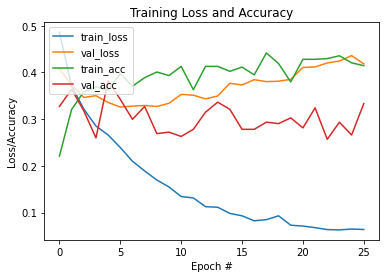

GloveEmbedding_DNN_Classfr 0.6953441295546559 0.897170837867247 0.8151260504201681 0.7627997563053248 0.8541828541828542 0.05180345969819654


In [25]:
Glove_Emb= Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length)
 
labels = sorted(target_variables)

model_DNN = Sequential()
model_DNN.add(Glove_Emb)
model_DNN.add(Dense(126, activation='relu'))
model_DNN.add(Dropout(0.3))
model_DNN.add(GlobalMaxPooling1D())
model_DNN.add(Dense(64, activation='relu'))
model_DNN.add(Dropout(0.2))
model_DNN.add(Flatten())
model_DNN.add(Dense(11, activation='sigmoid'))

model_DNN.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.002,name='Adam'),
                  loss='binary_crossentropy',
                  metrics=['accuracy','AUC'])

X_train, X_test, y_train, y_test = train_test_split(padded_docs, lupus_dataset[labels], test_size=0.33,shuffle=True)
history = model_DNN.fit(X_train, y_train,
                        epochs=26,
                        verbose=True,
                        validation_data=(X_test,y_test),
                        batch_size=12)

model_DNN.summary()
# plot metrics
from matplotlib import pyplot

pyplot.figure()
N = 26
pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
pyplot.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
pyplot.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
pyplot.title("Training Loss and Accuracy")
pyplot.xlabel("Epoch #")
pyplot.ylabel("Loss/Accuracy")
pyplot.legend(loc="upper left")
pyplot.show()

results=[]
pred = model_DNN.predict(padded_docs)

#pred
# for i, p in enumerate(pred[0]):
#     results.append({labels[i]: p})
#     print({labels[i]: 1 if p>=0.5 else 0})

#Training Performance evaluation
def p_to_class(x):
    x=1 if x>=0.5 else 0
    return x 
pred_df=pd.DataFrame(data=pred,columns=labels)
Glove_DNN_pred=pred_df.applymap(p_to_class)
metricsReport('GloveEmbedding_DNN_Classfr',lupus_dataset[labels],Glove_DNN_pred)


Model: CNN

In [26]:
#Creating an object named 'tokenizer' for tokenizer function and inserting the num_words and lower keywords in it. 
tokenizer = Tokenizer(num_words=5000, lower=True)
tokenizer.fit_on_texts(lupus_dataset['text'])

#Creating an object named 'sequence' and fitting Text column from dataset in texts_to_sequences method 
sequences = tokenizer.texts_to_sequences(lupus_dataset['text'])

#Creating an object and assigning the numeric value of 200
maxlen = 200

#Creating an object named 'x' for pad_sequence and this variable will be further used as an input variable
x = pad_sequences(sequences, maxlen=maxlen)

#Creating an object named max_words and assigning lenght of tokens
max_words = len(tokenizer.word_index) + 1

#Creating an object named as 'embeddings_dictionary' and passing through it dict to convert into a dictonary 
embeddings_dictionary = dict()

#Already downloaded glove file to local system
#Creating an object named as 'glove_file' and importing glove file into it
glove_file = open('glove.6B.100d.txt', encoding="utf8")

#Implementing a for loop in glove file
#records: Splitting all the words
#word: adding words in list
#vector_dimensions: Converting the type into float32
#embeddings_dictionary: passing words into embeddings_dictionary
#glove_file.close: closing the glove file to avoid the error 
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

#Creating an object named as 'embedding_matrix' and assigning it matrix of zeros
embedding_matrix = zeros((max_words, 100))

#Creating For loop 
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [27]:
labels = sorted(target_variables)

Epoch 1/30
83/83 [==============================] - 2s 16ms/step - loss: 0.5628 - accuracy: 0.2080 - val_loss: 0.4186 - val_accuracy: 0.1804
Epoch 2/30
83/83 [==============================] - 1s 15ms/step - loss: 0.4052 - accuracy: 0.2267 - val_loss: 0.3848 - val_accuracy: 0.2783
Epoch 3/30
83/83 [==============================] - 1s 15ms/step - loss: 0.3580 - accuracy: 0.3521 - val_loss: 0.3577 - val_accuracy: 0.3272
Epoch 4/30
83/83 [==============================] - 1s 16ms/step - loss: 0.3016 - accuracy: 0.4108 - val_loss: 0.3382 - val_accuracy: 0.3578
Epoch 5/30
83/83 [==============================] - 1s 15ms/step - loss: 0.2676 - accuracy: 0.3975 - val_loss: 0.3233 - val_accuracy: 0.3333
Epoch 6/30
83/83 [==============================] - 1s 15ms/step - loss: 0.2135 - accuracy: 0.4490 - val_loss: 0.3153 - val_accuracy: 0.3486
Epoch 7/30
83/83 [==============================] - 1s 16ms/step - loss: 0.1841 - accuracy: 0.4459 - val_loss: 0.3151 - val_accuracy: 0.3364
Epoch 8/30
83

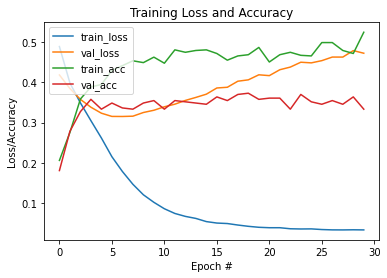

Model1_CNN_Classfr 0.694331983805668 0.9291109819872168 0.7904102817597627 0.7689829279451097 0.8541666666666667 0.050239234449760764


In [28]:
from matplotlib import pyplot
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
embedding_vecor_length = 32
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index


results = []

#  Number of times that the algorithm should run : we can change it to 10 and get the average
num_of_iterations = 1
for j in range(0,num_of_iterations):

    model1 = Sequential()
    model1.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model1.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu')) 
    model1.add(GlobalMaxPooling1D())
#   model1.add(LSTM(256))
    model1.add(Dropout(0.2))

    model1.add(Dense(11, activation='sigmoid'))
    model1.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    X_train, X_test, y_train, y_test = train_test_split(x, lupus_dataset[labels], test_size=0.33,shuffle=True)
    history = model1.fit(X_train, y_train,
                        epochs=30,
                        verbose=True,
                        validation_data=(X_test, y_test),
                        batch_size=8)

    model1.summary()
    # plot metrics
    
pyplot.figure()
N = 30
pyplot.plot(np.arange(0, N), history.history["loss"], label="train_loss")
pyplot.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
pyplot.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
pyplot.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
pyplot.title("Training Loss and Accuracy")
pyplot.xlabel("Epoch #")
pyplot.ylabel("Loss/Accuracy")
pyplot.legend(loc="upper left")
pyplot.show()

results=[]
pred = model1.predict(x)

#pred
# for i, p in enumerate(pred[0]):
#     results.append({labels[i]: p})
#     print({labels[i]: 1 if p>=0.5 else 0})

#Training Performance evaluation
def p_to_class(x):
    x=1 if x>=0.5 else 0
    return x 
pred_df=pd.DataFrame(data=pred,columns=labels)
Model1_pred=pred_df.applymap(p_to_class)
metricsReport('Model1_CNN_Classfr',lupus_dataset[labels],Model1_pred)


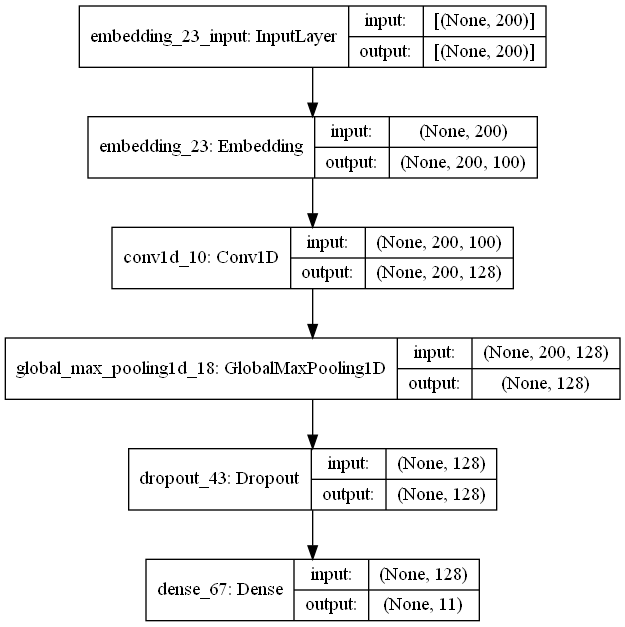

In [67]:
from keras.utils import plot_model
plot_model(model1, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)


In [12]:
treatment, diagnosis, outcome, symptome, etiology, Epidemiologic  = 0 , 0, 0, 0, 0, 0
metanalysis_Systematic_review, Orginal_Article, Case_report, letterShortCommon, Review = 0, 0, 0, 0, 0

for item in enumerate(results):
    for key,val in (item[1].items()):
        if(key=='treatment'):
            treatment = treatment + val
        elif(key=='diagnosis'):
            diagnosis = diagnosis + val
        elif(key=='outcome'):
            outcome = outcome + val
        elif(key=='symptome'):
            symptome = symptome + val
        elif(key=='etiology'):
            etiology = etiology + val
        elif(key=='epidemiologic'):
            Epidemiologic = Epidemiologic + val
        elif(key=='orginal_article'):
            Orginal_Article = Orginal_Article + val
        elif(key=='metanalysis_systematic_review'):
            metanalysis_Systematic_review = metanalysis_Systematic_review + val
        elif(key=='case_report'):
            Case_report = Case_report + val
        elif(key=='letter_short_common'):
            letterShortCommon = letterShortCommon + val
        elif(key=='review'):
            Review = Review + val
            
   
print('treatment = ', treatment /num_of_iterations)
print('diagnosis = ', diagnosis /num_of_iterations)
print('outcome = ', outcome /num_of_iterations)
print('symptome = ', symptome /num_of_iterations)
print('etiology = ', etiology /num_of_iterations)
print('Epidemiologic = ', Epidemiologic /num_of_iterations)
print('Orginal_Article = ', Orginal_Article /num_of_iterations)
print('metanalysis_Systematic_review = ', metanalysis_Systematic_review /num_of_iterations)
print('Case_report = ', Case_report /num_of_iterations)
print('letterShortCommon = ', letterShortCommon /num_of_iterations)
print('Review = ', Review /num_of_iterations)

treatment =  0.38126181066036224
diagnosis =  0.2648605406284332
outcome =  0.11573062837123871
symptome =  0.37460799515247345
etiology =  0.5820045471191406
Epidemiologic =  0.2137465626001358
Orginal_Article =  0.2843508720397949
metanalysis_Systematic_review =  0.23062631487846375
Case_report =  0.421034500002861
letterShortCommon =  0.21265171468257904
Review =  0.35101693868637085


In [17]:
#Evaluation 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss
ModelsPerformance = {}

def metricsReport(modelName, test_labels, predictions):
    acc=accuracy_score(test_labels, predictions)
    precision=precision_score(test_labels, predictions,average='weighted')
    recall=recall_score(test_labels, predictions,average='weighted')
    macro_f1 = f1_score(test_labels, predictions, average='macro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')   
    hamLoss = hamming_loss(test_labels, predictions)
    print(modelName,acc,precision,recall,macro_f1,micro_f1,hamLoss )

#### TESTING

In [70]:
test_data=pd.read_excel('test_lupus.xlsx')
test_data.head()

,Text,treatment,outcome,diagnosis,symptome,etiology,epidemiologic,not_categorised,orginal_article,metanalysis_systematic_review,case_report,letter_short_common,review
0,Neuropsychiatric involvement in systemic lupus...,0,0,0,0,0,0,0,0,0,0,0,0
1,PECULIARITIES OF BONE MINERAL DENSITY IN WOMEN...,0,1,0,0,0,0,0,1,0,0,0,0
2,[Effect of COVID-19 confinement on the mental ...,0,1,0,1,0,0,0,1,0,0,0,0
3,Cerebellar ataxia as a primary manifestation o...,0,0,0,1,0,0,0,0,0,1,0,0
4,Antinuclear Antibody Testing for the Diagnosis...,0,0,1,0,0,0,0,0,0,0,0,1


In [72]:
encoded_test_docs = t.texts_to_sequences(test_data['Text'])
# print(encoded_test_docs)
# pad documents to a max length of 200 words
padded_test_docs = pad_sequences(encoded_test_docs, maxlen=max_length, padding='post')
# print(padded_test_docs)

[[390, 191, 2, 1, 3, 78, 390, 191, 390, 1, 5, 27, 2, 1, 3, 390, 191, 2, 1, 3, 578, 673, 279, 88, 32, 4182, 366, 890, 273, 764, 1091, 3396, 1015, 578, 5035, 4399, 248, 19, 510, 172, 578, 3327, 1109, 768, 162, 1038, 1765, 1107, 213, 159, 2236, 1105, 998, 54, 146, 3138, 54, 117, 266, 162, 5, 208, 5363, 4371, 2124, 390, 823, 5290, 1096, 508, 728, 172, 578, 1211, 575, 146, 3182, 423, 6560, 3372, 390, 5, 3461, 279, 347, 772, 423, 1041, 141, 1418, 113, 764, 3279, 433, 1, 27, 1692, 399, 43, 1801, 515, 1231, 167, 5435, 1537, 3579, 390, 4809, 5, 701, 2130, 1654, 1092, 423, 219, 578, 205, 5426, 430, 1315, 1667, 296, 219, 1015, 578, 581, 764, 1099, 849, 1050, 1462, 23, 5, 208, 78, 279, 88, 219, 162, 1, 165, 291, 343, 67, 1, 3, 2, 172], [667, 8166, 1390, 162, 1480, 164, 2, 1, 3, 4219, 148, 150, 1098, 167, 8, 667, 8166, 1390, 146, 162, 1480, 164, 2, 1, 3, 370, 2980, 1761, 120, 2628, 2, 1, 3, 20, 4820, 5207, 667, 1390, 1, 3, 2, 1098, 14], [69, 656, 1015, 825, 315, 2, 1, 3, 656, 1015, 1, 3702, 10213, 

In [87]:
#GLOVE CNN Pred
pred = model_Glove.predict(padded_test_docs)

#Testing Performance evaluation
def p_to_class(x):
    x=1 if x>=0.4 else 0
    return x 
pred_df=pd.DataFrame(data=pred,columns=labels)
Glove_CNN_pred=pred_df.applymap(p_to_class)
metricsReport('GloveEmbedding_CNN_Classfr',test_data[labels],Glove_CNN_pred)
print(Glove_CNN_pred.head)

##GLOVE DNN Pred

pred = model_DNN.predict(padded_test_docs)

#Testing Performance evaluation

pred_df=pd.DataFrame(data=pred,columns=labels)
Glove_DNN_pred=pred_df.applymap(p_to_class)
metricsReport('GloveEmbedding_DNN_Classfr',test_data[labels],Glove_DNN_pred)
print(Glove_DNN_pred)

##GLOVE LSTM Pred

pred = model_LSTM.predict(padded_test_docs)

#Testing Performance evaluation

pred_df=pd.DataFrame(data=pred,columns=labels)
Glove_LSTM_pred=pred_df.applymap(p_to_class)
metricsReport('GloveEmbedding_LSTM_Classfr',test_data[labels],Glove_LSTM_pred)
print(Glove_LSTM_pred)

##Existing Model 

pred = model1.predict(padded_test_docs)

#Testing Performance evaluation
pred_df=pd.DataFrame(data=pred,columns=labels)
Model1_pred=pred_df.applymap(p_to_class)
metricsReport('Model1_CNN_Classfr',test_data[labels],Model1_pred)
print(Model1_pred)

GloveEmbedding_CNN_Classfr 0.25 0.5714285714285714 0.6 0.22727272727272727 0.6666666666666665 0.10227272727272728
<bound method NDFrame.head of    case_report  diagnosis  epidemiologic  etiology  letter_short_common  \
0            0          0              0         0                    0   
1            0          0              0         0                    0   
2            0          0              0         0                    0   
3            0          0              0         0                    0   
4            0          0              0         0                    0   
5            0          0              0         1                    0   
6            0          0              0         1                    0   
7            0          0              0         1                    0   

   metanalysis_systematic_review  orginal_article  outcome  review  symptome  \
0                              0                1        0       0         0   
1                   

C:\Users\Tress\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tress\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Tress\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
C:\Users\Tress\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and 

Recent cases--testing

In [30]:
test_data=pd.read_excel('test_cases_new.xlsx')
test_data.head()
encoded_test_docs = t.texts_to_sequences(test_data['Text'])
# print(encoded_test_docs)
# pad documents to a max length of 200 words
padded_test_docs = pad_sequences(encoded_test_docs, maxlen=max_length, padding='post')
# print(padded_test_docs)

[[390, 191, 2, 1, 3, 78, 390, 191, 390, 1, 5, 27, 2, 1, 390, 191, 2, 1, 3, 577, 671, 279, 88, 33, 4172, 366, 888, 273, 762, 1087, 3388, 1011, 577, 5025, 4389, 248, 19, 509, 172, 577, 3319, 1105, 766, 162, 1034, 1760, 1103, 213, 159, 2230, 1101, 994, 54, 146, 3130, 54, 117, 266, 162, 5, 208, 5353, 4361, 2118, 390, 821, 5280, 1092, 507, 726, 172, 577, 1207, 574, 146, 3174, 422, 6549, 3364, 390, 5, 3453, 279, 347, 770, 422, 1037, 141, 1413, 113, 762, 3271, 432, 1, 27, 1687, 399, 43, 1796, 514, 1227, 167, 5425, 1532, 3569, 390, 4799, 5, 699, 2124, 1649, 1088, 422, 219, 577, 205, 5416, 429, 1311, 1662, 296, 219, 1011, 577, 580, 762, 1095, 847, 1046, 1457, 23, 5, 208, 78, 279, 88, 219, 162, 1, 165, 291, 343, 67, 1, 3, 2, 172], [665, 8155, 1385, 162, 1475, 164, 2, 1, 3, 4209, 148, 150, 167, 8, 665, 8155, 1385, 146, 162, 1475, 164, 2, 1, 3, 370, 2973, 1756, 120, 2621, 2, 1, 3, 20, 4810, 5197, 665, 1385, 1, 3, 2, 1094, 14], [2, 1, 3, 6086, 1218, 89, 2607, 469, 2, 1, 1665, 87, 433, 99, 804, 1281

In [32]:

#Testing Performance evaluation
def p_to_class(x):
    x=1 if x>=0.4 else 0
    return x 

##GLOVE DNN Pred

pred = model_DNN.predict(padded_test_docs)

#Testing Performance evaluation

pred_df=pd.DataFrame(data=pred,columns=labels)
Glove_DNN_pred=pred_df.applymap(p_to_class)
Glove_DNN_pred=pd.concat([Glove_DNN_pred, test_data], axis=1)
Glove_DNN_pred.to_csv('DNN_results.csv',index=True)
Glove_DNN_pred.head()

,case_report,diagnosis,epidemiologic,etiology,letter_short_common,metanalysis_systematic_review,orginal_article,outcome,review,symptome,treatment,Text
0,0,0,0,0,0,0,1,0,0,1,0,Neuropsychiatric involvement in systemic lupus...
1,0,0,0,0,0,0,1,0,0,1,0,PECULIARITIES OF BONE MINERAL DENSITY IN WOMEN...
2,1,0,0,0,0,0,0,0,0,1,0,Moyamoya angiopathy unmasking systemic lupus e...
3,0,0,0,0,0,0,1,0,0,0,0,[Clinical Features and Risk Factors of Systemi...
4,0,0,0,0,0,0,1,1,0,0,0,[Effect of COVID-19 confinement on the mental ...


In [34]:
pred =  model1.predict(padded_test_docs)

#Testing Performance evaluation

pred_df=pd.DataFrame(data=pred,columns=labels)
CNN_pred=pred_df.applymap(p_to_class)
CNN_pred=pd.concat([CNN_pred, test_data], axis=1)
CNN_pred.to_csv('CNN_results.csv',index=True)
CNN_pred.head()

,case_report,diagnosis,epidemiologic,etiology,letter_short_common,metanalysis_systematic_review,orginal_article,outcome,review,symptome,treatment,Text
0,0,0,0,0,0,0,0,0,0,0,0,Neuropsychiatric involvement in systemic lupus...
1,0,0,0,1,0,0,1,0,0,0,0,PECULIARITIES OF BONE MINERAL DENSITY IN WOMEN...
2,0,0,0,0,0,0,0,0,0,1,0,Moyamoya angiopathy unmasking systemic lupus e...
3,0,0,0,0,0,0,1,0,0,0,0,[Clinical Features and Risk Factors of Systemi...
4,0,0,0,1,0,0,1,0,0,0,0,[Effect of COVID-19 confinement on the mental ...
